<a href="https://colab.research.google.com/github/young-hyun-park/HW/blob/main/2d_liver_segmentation_only_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import torch.nn.functional as F
import albumentations.pytorch
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import cv2 
import nibabel as nib

In [ ]:
seed = 1

lr = 0.001
momentum = 0.99

batch_size = 3
test_batch_size = 3

epochs = 10
log_interval = 10

In [ ]:
PATH = '/content/drive/MyDrive'

In [ ]:
train_image_path =os.path.join(PATH+'/train_image')
train_mask_path = os.path.join(PATH+'/train_mask')
validation_image_path = os.path.join(PATH+'/validation_image')
validation_mask_path = os.path.join(PATH+'/validation_mask')

In [ ]:
df_train_path = pd.read_csv('/content/drive/MyDrive/train_image/only_mask_train_path.csv')
df_val_path = pd.read_csv('/content/drive/MyDrive/validation_image/only_mask_val_path.csv')

In [ ]:
df_train_path_shuffle=df_train_path['0'].sample(frac=1).reset_index(drop = True)
df_val_path_shuffle=df_val_path['0'].sample(frac=1).reset_index(drop = True)

In [ ]:
type(df_train_path_shuffle[:2000].to_numpy())

numpy.ndarray

In [ ]:
train_path = df_train_path_shuffle[:1900].to_numpy()
val_path = df_val_path_shuffle.iloc[:300].to_numpy()

In [ ]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img_name = path.split('/')[-1]
        file_name = path.split('/')[-2]
        iamge_path = train_image_path + '/' + file_name + '/'+img_name
        img = np.load(iamge_path)
        img[img <-15 ] = 0
        img[img > 135] = 255
        img = 255*(img+15)/150
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_CUBIC)
        img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
        image = cv2.normalize(img,None,alpha = 0, beta = 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        image = image[:,:,np.newaxis]

        mask = np.load(path)
        mask[mask == 2] = 1
        mask = cv2.resize(mask, (128,128), interpolation = cv2.INTER_CUBIC)
        mask = cv2.rotate(mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        image = image.transpose(2,0,1)
        mask_ = torch.as_tensor(mask.copy())
        image_ = torch.as_tensor(image.copy())
        sample = {'image':image_, 'mask' : mask_}
        return sample
        

In [ ]:
class Val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img_name = path.split('/')[-1]
        file_name = path.split('/')[-2]
        iamge_path = validation_image_path + '/' + file_name + '/'+img_name
        img = np.load(iamge_path)
        img[img <-15 ] = 0
        img[img > 135] = 255
        img = 255*(img+15)/150
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_CUBIC)
        img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
        image = cv2.normalize(img,None,alpha = 0, beta = 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        image = image[:,:,np.newaxis]

        mask = np.load(path)
        mask[mask == 2 ] = 1
        mask = cv2.resize(mask, (128,128), interpolation = cv2.INTER_CUBIC)
        mask = cv2.rotate(mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        image = image.transpose(2,0,1)
        mask_ = torch.as_tensor(mask.copy())
        image_ = torch.as_tensor(image.copy())
        sample = {'image':image_, 'mask' : mask_}
        return sample
        

In [ ]:
train_data = Train_Dataset(train_path,transform = None)
val_data = Val_Dataset(val_path)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
)
test_loader = torch.utils.data.DataLoader(
    val_data,
        batch_size = batch_size,
    shuffle = False,
)

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(2).to(device)

In [ ]:
summary(net,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
from torch import Tensor
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]
def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]
    
def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas
            if clas ==0:
              iou_per_class.append(np.nan)
            elif true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
!nvidia-smi

Mon Nov 22 07:50:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |  10070MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ps aux | grep python

root          37  0.0  0.2 160352 32904 ?        S    03:22   0:00 python3 /usr/local/bin/colab-fileshim.py
root         260  0.0  0.0  18380  1776 ?        S    03:45   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         262  0.0  0.0  32324  8180 ?        S    03:45   0:01 python3 /opt/google/drive/drive-filter.py
root        2581  0.1  0.4 194916 54128 ?        Sl   07:00   0:04 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root        2588 23.3 28.8 24430964 3834544 ?    Ssl  07:00  11:35 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-41d38598-97f4-422f-8eb6-9588a39feea9.json
root        2608  0.3  0.1 129176 15568 ?        Sl   07:00   0:09 /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/debugpy/a

In [ ]:
!sudo kill -9 2212

kill: (2212): No such process


In [ ]:
import time
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr = 1e-4)
train_loss= list()
train_dice = list()
train_acc = list()
loss_val = list()
val_dice = list()
val_acc = list()
state = list()
PATH = '/content/drive/MyDrive/Task03_Liver/Task03_Liver/model/'
for epoch in range(1, epochs + 1):
    # Train Mode
    net.train()
    start  = time.time()
    losses = 0
    train_acc_ = 0
    dice_coef = 0
    for batch_idx, data in enumerate(train_loader):
        inputs = data['image']
        inputs = inputs.to(device = device,dtype = torch.float32)
        masks = data['mask']
        labels = masks.to(device = device,dtype = torch.long)
        optimizer.zero_grad()
        masks_pred = net(inputs)
        loss = criterion(masks_pred,labels)

        loss.backward()
        optimizer.step()
        losses += loss.item()
        dice_coef += multiclass_dice_coeff(F.softmax(masks_pred,dim = 1).float(),F.one_hot(labels,num_classes= 2).permute(0,3,1,2).float())
        train_acc_ += pixel_accuracy(masks_pred, labels)
    print('\nTrain Epoch: {},Loss: {:.6f},Dice_coef: {:.4f}, Accuracy : {:.3f},Time :{:.1f}'.format(
        epoch, losses/len(train_loader),dice_coef/len(train_loader),train_acc_/len(train_loader),int(time.time()-start)))
    train_loss.append(losses/len(train_loader))
    train_dice.append(dice_coef/len(train_loader))
    train_acc.append(train_acc_/len(train_loader))
    state.append(net.state_dict())
    torch.save({
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch' : epoch
            }, PATH+'test_unet_only_mask_epoch{}_checkpoint'.format(epoch))

    # Test mode
    net.eval()
    val_loss = 0
    test_iou = 0
    val_acc_ = 0
    test_dice = 0
    with torch.no_grad():
        for data in test_loader:
          inputs = data['image']
          inputs_test = inputs.to(device = device,dtype = torch.float32)
          masks = data['mask']
          labels_test = masks.to(device = device,dtype = torch.long)
          test_masks_pred = net(inputs_test)
          loss = criterion(test_masks_pred,labels_test)
          val_loss += loss.item() # sum up batch loss
          test_dice += multiclass_dice_coeff(F.softmax(test_masks_pred,dim = 1).float(),F.one_hot(labels_test,num_classes= 2).permute(0,3,1,2).float())
          val_acc_ +=  pixel_accuracy(test_masks_pred, labels_test)
    val_loss /= len(test_loader)
    loss_val.append(val_loss)
    val_dice.append(test_dice/len(test_loader))
    val_acc.append(val_acc_/len(test_loader))

    print('Val set: Average loss: {:.4f},Dice_coef: {:.4f}, Accuracy : {:.4f}'.format(val_loss,test_dice/len(test_loader),val_acc_/len(test_loader)))


Train Epoch: 1,Loss: 0.119455,Dice_coef: 0.7104, Accuracy : 0.984,Time :97.0
Val set: Average loss: 0.0519,Dice_coef: 0.7833, Accuracy : 0.9900

Train Epoch: 2,Loss: 0.044202,Dice_coef: 0.8261, Accuracy : 0.990,Time :99.0
Val set: Average loss: 0.0310,Dice_coef: 0.8420, Accuracy : 0.9917

Train Epoch: 3,Loss: 0.028736,Dice_coef: 0.8741, Accuracy : 0.992,Time :98.0
Val set: Average loss: 0.0264,Dice_coef: 0.8839, Accuracy : 0.9912

Train Epoch: 4,Loss: 0.021817,Dice_coef: 0.8994, Accuracy : 0.993,Time :98.0
Val set: Average loss: 0.0217,Dice_coef: 0.8868, Accuracy : 0.9929

Train Epoch: 5,Loss: 0.019481,Dice_coef: 0.9127, Accuracy : 0.993,Time :100.0
Val set: Average loss: 0.0202,Dice_coef: 0.9001, Accuracy : 0.9929

Train Epoch: 6,Loss: 0.017130,Dice_coef: 0.9226, Accuracy : 0.994,Time :99.0
Val set: Average loss: 0.0182,Dice_coef: 0.9165, Accuracy : 0.9935

Train Epoch: 7,Loss: 0.014566,Dice_coef: 0.9342, Accuracy : 0.995,Time :98.0
Val set: Average loss: 0.0206,Dice_coef: 0.9094, Ac

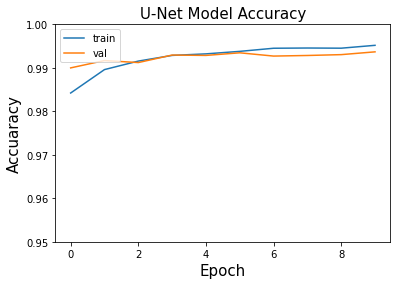

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc) 
plt.title('U-Net Model Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuaracy', fontsize = 15)
plt.ylim(0.95,1)
plt.legend(['train','val'], loc='upper left')
plt.show()

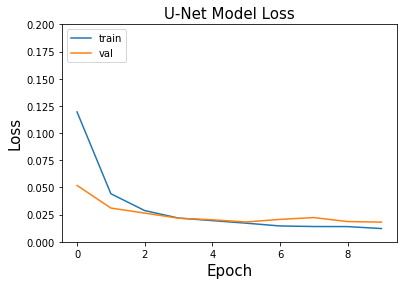

In [ ]:
plt.plot(train_loss)
plt.plot(loss_val)
plt.title('U-Net Model Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,0.2)
plt.legend(['train','val'], loc='upper left')
plt.show()

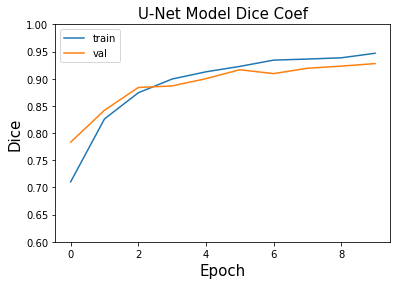

In [ ]:
plt.plot(train_dice)
plt.plot(val_dice)
plt.title('U-Net Model Dice Coef', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Dice', fontsize = 15)
plt.ylim(0.6,1)
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
pred = F.softmax(test_masks_pred,dim = 1)
prediction = torch.argmax(pred,dim = 1)
prediction.shape

torch.Size([3, 128, 128])

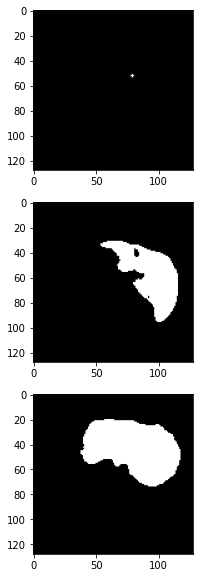

In [ ]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(prediction[i].cpu().data.numpy(),'gray')

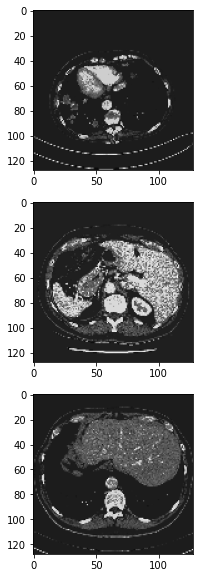

In [ ]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(torch.squeeze(inputs_test[i]).cpu().data.numpy(),'gray')

In [ ]:
inputs_test.shape

torch.Size([3, 1, 128, 128])

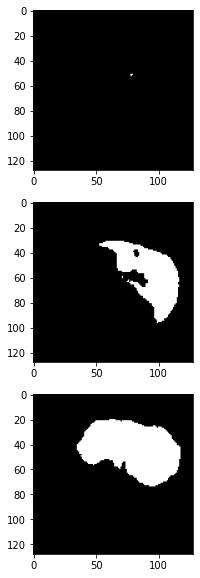

In [ ]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(torch.squeeze(labels_test[i]).cpu().data.numpy(),'gray')